In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']
# matplotlib.rc('pdf', fonttype=42)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import itertools

In [5]:
# Ground truth MDP model
MDP_parameters = joblib.load('../data/MDP_parameters.joblib')
P = MDP_parameters['transition_matrix_absorbing'] # (A, S, S_next)
R = MDP_parameters['reward_matrix_absorbing_SA'] # (S, A)
nS, nA = R.shape
gamma = 0.99

# unif rand isd, mixture of diabetic state
PROB_DIAB = 0.2
isd = joblib.load('../data/modified_prior_initial_state_absorbing.joblib')
isd = (isd > 0).astype(float)
isd[:720] = isd[:720] / isd[:720].sum() * (1-PROB_DIAB)
isd[720:] = isd[720:] / isd[720:].sum() * (PROB_DIAB)

# Optimal value function and optimal return
V_star = joblib.load('../data/V_π_star_PE.joblib')
J_star = V_star @ isd

In [6]:
num_runs = 10

In [7]:
to_plot = 'Regret'

In [8]:
layers_list = [1, 2]
units_list = [100, 200, 500, 1000]
lr_list = [1e-3, 1e-4]
k_list = [1, 2, 4, 8, 16, 32]

In [9]:
keys = [str((nl, nh, lr, k)) for nl, nh, lr, k in itertools.product(layers_list, units_list, lr_list, k_list)]

In [10]:
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(matplotlib.colors.to_rgb(c1))
    c2=np.array(matplotlib.colors.to_rgb(c2))
    return matplotlib.colors.to_hex((1-mix)*c1 + mix*c2)

In [11]:
def twostage(dfs_values):
    subset_sizes = [1, 6, 12, 24, 48, 96]
    all_results = []
    for r in range(num_runs):
        results = {}
        df_r = dfs_values[r]
        true_value_list = np.array(df_r['true_value_list'])
        WIS_value_list = np.array(df_r['WIS_value_list'])
        FQE_value_list = np.array(df_r['FQE_value_list'])
        for subset_size in subset_sizes:
            subset_inds = np.argsort(WIS_value_list)[-subset_size:]
            perf = true_value_list[subset_inds][np.argmax(FQE_value_list[subset_inds])]
            results['two-stage, '+str(subset_size)] = np.max(true_value_list) - perf
        all_results.append(results)
    df_regrets_twostage = pd.DataFrame(all_results)

#     df_regrets_twostage.loc[3, ['two-stage, 6', 'two-stage, 12']] += 8e-3 # A hack to make points more discernable
    return df_regrets_twostage

## Exp vasize

In [12]:
dfs_results_va10k = [pd.read_csv('../exp--main/results/run{}/sepsis-cont-HP-va.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_values_va10k = [pd.read_csv('../exp--main/results/run{}/sepsis-cont-HP-va.values.csv'.format(run)).set_index('(nl, nh, lr, k)').loc[keys] for run in range(num_runs)]

In [13]:
dfs_results_va500 = [pd.read_csv('../exp-vasize/results/run{}/sepsis-cont-HP-va500.csv'.format(run)) for run in range(num_runs)]
dfs_values_va500 = [pd.read_csv('../exp-vasize/results/run{}/sepsis-cont-HP-va500.values.csv'.format(run)) for run in range(num_runs)]

In [14]:
dfs_results_va1k = [pd.read_csv('../exp-vasize/results/run{}/sepsis-cont-HP-va1k.csv'.format(run)) for run in range(num_runs)]
dfs_values_va1k = [pd.read_csv('../exp-vasize/results/run{}/sepsis-cont-HP-va1k.values.csv'.format(run)) for run in range(num_runs)]

In [15]:
dfs_results_va5k = [pd.read_csv('../exp-vasize/results/run{}/sepsis-cont-HP-va5k.csv'.format(run)) for run in range(num_runs)]
dfs_values_va5k = [pd.read_csv('../exp-vasize/results/run{}/sepsis-cont-HP-va5k.values.csv'.format(run)) for run in range(num_runs)]

In [16]:
dfs_va10k = [pd.read_csv('../exp--main/results/run{}/sepsis-cont-HP-va.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va500 = [pd.read_csv('../exp-vasize/results/run{}/sepsis-cont-HP-va500.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va1k = [pd.read_csv('../exp-vasize/results/run{}/sepsis-cont-HP-va1k.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va5k = [pd.read_csv('../exp-vasize/results/run{}/sepsis-cont-HP-va5k.csv'.format(run), index_col=0) for run in range(num_runs)]

In [17]:
regrets_va10k = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va10k)], axis=1).T.drop(columns=['FQI'])
regrets_va10k['Case'] = '10k'
regrets_va5k = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va5k)], axis=1).T.drop(columns=['FQI'])
regrets_va5k['Case'] = '5k'
regrets_va1k = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va1k)], axis=1).T.drop(columns=['FQI'])
regrets_va1k['Case'] = '1k'
regrets_va500 = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va500)], axis=1).T.drop(columns=['FQI'])
regrets_va500['Case'] = '500'

In [18]:
regrets_exp2 = pd.concat([regrets_va500, regrets_va1k, regrets_va5k, regrets_va10k])
regrets_exp2.columns.name = 'OPE'
regrets_exp2 = pd.DataFrame(regrets_exp2.set_index('Case').stack().rename(to_plot)).reset_index()

In [19]:
regrets_exp2 = regrets_exp2[regrets_exp2['OPE'].isin(['WIS', 'AM', 'FQE'])]

In [20]:
regrets_exp2 = regrets_exp2 \
.append(pd.DataFrame([
    ['500' for _ in range(num_runs)],
    ['two-stage, 24' for _ in range(num_runs)],
    twostage(dfs_values_va500)['two-stage, 24'].values,
], index=regrets_exp2.columns).T, ignore_index=True) \
.append(pd.DataFrame([
    ['1k' for _ in range(num_runs)],
    ['two-stage, 24' for _ in range(num_runs)],
    twostage(dfs_values_va1k)['two-stage, 24'].values,
], index=regrets_exp2.columns).T, ignore_index=True) \
.append(pd.DataFrame([
    ['5k' for _ in range(num_runs)],
    ['two-stage, 24' for _ in range(num_runs)],
    twostage(dfs_values_va5k)['two-stage, 24'].values,
], index=regrets_exp2.columns).T, ignore_index=True) \
.append(pd.DataFrame([
    ['10k' for _ in range(num_runs)],
    ['two-stage, 24' for _ in range(num_runs)],
    twostage(dfs_values_va10k)['two-stage, 24'].values,
], index=regrets_exp2.columns).T, ignore_index=True)

regrets_exp2['Regret'] = regrets_exp2['Regret'].astype(float)

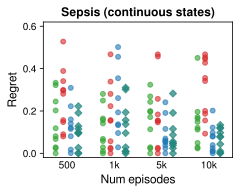

In [21]:
df = regrets_exp2.groupby(['Case', 'OPE']).agg(['min', 'median', 'max']).unstack()
df.columns = df.columns.droplevel()
df = df.loc[['500', '1k', '5k', '10k']]
ncases, nlines = df.loc[:,'median'].shape

fig, ax = plt.subplots(figsize=(3.4, 2.5))
for i, (name, color, mark) in enumerate(zip(
    ['WIS', 'AM', 'FQE', 'two-stage, 24'],
    ['tab:green', 'tab:red', 'tab:blue', colorFader('tab:green', 'tab:blue', 0.6)],
    ['o', 'd', '^', 'o']
)):
    xpos = np.arange(ncases) + 0.16 * (i+0.5-nlines/2)
    
    yval, ylo, yhi = df.loc[:,('median', name)], df.loc[:,('min', name)], df.loc[:,('max', name)]
    yerrs = np.array([yval-ylo, yhi-yval])
    
    yvals = regrets_exp2[regrets_exp2['OPE'] == name][to_plot].values.reshape((ncases, num_runs))
    if name != 'two-stage, 24':
        plt.plot(xpos, yvals, ls='None', c=color, marker='o', markersize=5, markeredgewidth=1, zorder=10, alpha=0.6)
    else:
        plt.plot(xpos, yvals, ls='None', c=color, marker='D', markersize=5, markeredgewidth=1, zorder=10, alpha=0.75)

plt.xticks([0,1,2,3], ['500', '1k', '5k', '10k'])
plt.xlim(-0.5, 3.5)
plt.ylim(-0.02, 0.62)

ax.tick_params(axis='x', length=0)
plt.xlabel('Num episodes', fontsize=12)
plt.ylabel(to_plot, fontsize=12)
plt.title('Sepsis (continuous states)', fontsize=12, fontweight='bold')
plt.savefig('fig/sepsis-cont-exp-HP-size.pdf', bbox_inches='tight')
plt.show()

## Exp behavior

In [22]:
dfs_results_va10k = [pd.read_csv('../exp--main/results/run{}/sepsis-cont-HP-va.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_values_va10k = [pd.read_csv('../exp--main/results/run{}/sepsis-cont-HP-va.values.csv'.format(run)).set_index('(nl, nh, lr, k)').loc[keys] for run in range(num_runs)]

In [23]:
dfs_results_va10k_eps01 = [pd.read_csv('../exp-beh/results/run{}/sepsis-cont-HP-va10k_eps01.csv'.format(run)) for run in range(num_runs)]
dfs_values_va10k_eps01 = [pd.read_csv('../exp-beh/results/run{}/sepsis-cont-HP-va10k_eps01.values.csv'.format(run)) for run in range(num_runs)]

In [24]:
dfs_results_va10k_mixed = [pd.read_csv('../exp-beh/results/run{}/sepsis-cont-HP-va10k_mixed.csv'.format(run)) for run in range(num_runs)]
dfs_values_va10k_mixed = [pd.read_csv('../exp-beh/results/run{}/sepsis-cont-HP-va10k_mixed.values.csv'.format(run)) for run in range(num_runs)]

In [25]:
dfs_va10k = [pd.read_csv('../exp--main/results/run{}/sepsis-cont-HP-va.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va10k_eps01 = [pd.read_csv('../exp-beh/results/run{}/sepsis-cont-HP-va10k_eps01.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va10k_mixed = [pd.read_csv('../exp-beh/results/run{}/sepsis-cont-HP-va10k_mixed.csv'.format(run), index_col=0) for run in range(num_runs)]

In [26]:
regrets_va10k = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va10k)], axis=1).T.drop(columns=['FQI'])
regrets_va10k['Case'] = 'Random'
regrets_va10k_eps01 = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va10k_eps01)], axis=1).T.drop(columns=['FQI'])
regrets_va10k_eps01['Case'] = 'ε-greedy'
regrets_va10k_mixed = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va10k_mixed)], axis=1).T.drop(columns=['FQI'])
regrets_va10k_mixed['Case'] = 'Mixed'

In [27]:
regrets_exp3 = pd.concat([regrets_va10k, regrets_va10k_mixed, regrets_va10k_eps01])
regrets_exp3.columns.name = 'OPE'
regrets_exp3 = pd.DataFrame(regrets_exp3.set_index('Case').stack().rename(to_plot)).reset_index()

In [28]:
regrets_exp3 = regrets_exp3[regrets_exp3['OPE'].isin(['WIS', 'AM', 'FQE'])]

In [29]:
regrets_exp3 = regrets_exp3 \
.append(pd.DataFrame([
    ['ε-greedy' for _ in range(num_runs)],
    ['two-stage, 24' for _ in range(num_runs)],
    twostage(dfs_values_va10k_eps01)['two-stage, 24'].values,
], index=regrets_exp3.columns).T, ignore_index=True) \
.append(pd.DataFrame([
    ['Mixed' for _ in range(num_runs)],
    ['two-stage, 24' for _ in range(num_runs)],
    twostage(dfs_values_va10k_mixed)['two-stage, 24'].values,
], index=regrets_exp3.columns).T, ignore_index=True) \
.append(pd.DataFrame([
    ['Random' for _ in range(num_runs)],
    ['two-stage, 24' for _ in range(num_runs)],
    twostage(dfs_values_va10k)['two-stage, 24'].values,
], index=regrets_exp3.columns).T, ignore_index=True)

regrets_exp3['Regret'] = regrets_exp3['Regret'].astype(float)

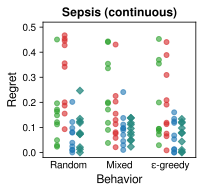

In [30]:
df = regrets_exp3.groupby(['Case', 'OPE']).agg(['min', 'median', 'max']).unstack()
df.columns = df.columns.droplevel()
df = df.loc[['Random', 'Mixed', 'ε-greedy']]
ncases, nlines = df.loc[:,'median'].shape

ncases = regrets_exp3['Case'].nunique()
fig, ax = plt.subplots(figsize=(2.75, 2.5))
for i, (name, color, mark) in enumerate(zip(
    ['WIS', 'AM', 'FQE', 'two-stage, 24'],
    ['tab:green', 'tab:red', 'tab:blue', colorFader('tab:green', 'tab:blue', 0.6)],
    ['o', 'd', '^', 'o']
)):
    yval, ylo, yhi = df.loc[:,('median', name)], df.loc[:,('min', name)], df.loc[:,('max', name)]
    yerrs = np.array([yval-ylo, yhi-yval])
    xpos = np.arange(ncases) + 0.15 * (i+0.5-nlines/2)

    yvals = regrets_exp3[regrets_exp3['OPE'] == name][to_plot].values.reshape((ncases, num_runs))
    if name != 'two-stage, 24':
        plt.plot(xpos, yvals, ls='None', c=color, marker='o', markersize=5, markeredgewidth=1, zorder=10, alpha=0.6)
    else:
        plt.plot(xpos, yvals, ls='None', c=color, marker='D', markersize=5, markeredgewidth=1, zorder=10, alpha=0.75)

plt.xlim(-0.5, 2.5)
plt.ylim(-0.02, 0.52)

ax.tick_params(axis='x', length=0)
plt.xticks([0,1,2], ['Random', 'Mixed', 'ε-greedy'])
plt.xlabel('Behavior', fontsize=12)
plt.ylabel(to_plot, fontsize=12)
plt.title('Sepsis (continuous)', fontsize=12, fontweight='bold')
plt.savefig('fig/sepsis-cont-exp-HP-behavior.pdf', bbox_inches='tight')
plt.show()